## 0.PRE

In [1]:
!python -V

Python 3.6.9


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import math

### mount google drive

In [4]:
#DRIVE_HOME='/content/drive/My Drive/python/sound/'
DRIVE_HOME=''
DATA_LOC = 'data/blues.00000.wav'

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

## Load 

### load sound files

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

<AxesSubplot:>

(-0.5, 694882.675, -30360.25, 31839.25)

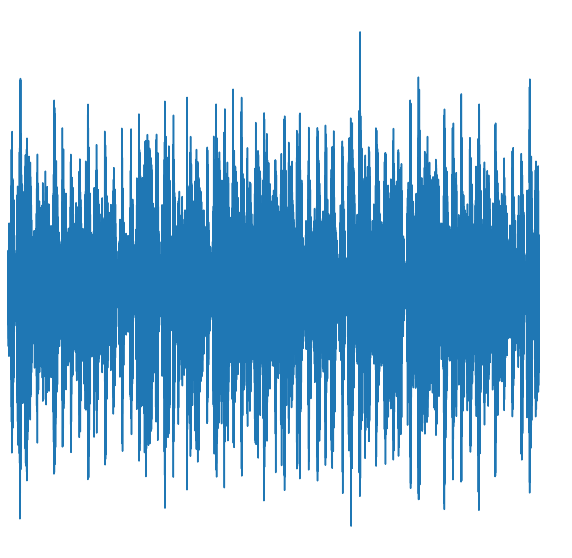

In [7]:
fig = plt.figure(figsize=(10,10))

plt.subplot()


# create spectogram
## read wave
samplerate, test_sound  = wavfile.read(DRIVE_HOME+DATA_LOC)
_, spectrogram = log_specgram(test_sound, samplerate)

plt.imshow(spectrogram.T, aspect='auto', origin='lower')

plt.plot(test_sound)

plt.axis('off')
plt.gray()

### file info

In [8]:
print(test_sound[:5])
print(len(test_sound))
print(len(test_sound)/30)
print(len(test_sound)/30/22000)

from math import sqrt, pow


## dimentionss
DIMEN_N = int(round(sqrt(len(test_sound)),0)-1) ; DIMEN_N_2 = DIMEN_N**2
print(DIMEN_N, ', pow :', DIMEN_N_2)
print('max : ', max(test_sound), ', min : ', min(test_sound))


[ 240  544  250 -115  -74]
661794
22059.8
1.0027181818181818
813 , pow : 660969
max :  29012 , min :  -27533


### reshape np array

In [9]:
## reshape
print(len(test_sound[0:DIMEN_N_2]))
test_sound_2d = test_sound[:DIMEN_N_2].reshape((DIMEN_N,DIMEN_N), order='F')
test_sound_2d.shape

660969


(813, 813)

### normalization

In [53]:
## normalization 
##############
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#test_sound_2d_norm = scaler.fit_transform(test_sound_2d) * 255
#test_sound_2d_norm = test_sound_2d_norm.astype(int)
#test_sound_2d_norm
##############

print(np.max(test_sound_2d), np.min(test_sound_2d))
min_val, max_val = np.min(test_sound_2d).astype(np.int32), np.max(test_sound_2d).astype(np.int32)

print(min_val, max_val );

29012 -27533
-27533 29012


In [54]:
max_val - min_val

56545

In [61]:
## normalization 
print(test_sound_2d - min_val)
### max_val - min_val ??? 


test_sound_2d_norm = ((test_sound_2d - min_val) / (max_val - min_val) * 255).astype(int)
test_sound_2d_norm
print('min_val : ', np.min(test_sound_2d_norm), '\t max_val : ', np.max(test_sound_2d_norm))

[[ 27773  27527  27471 ...  23939 -32524  23050]
 [ 28077  27183  27231 ...  25958 -31991  22032]
 [ 27783  26895  26942 ...  25981 -31542  21791]
 ...
 [ 27706  28570  31835 ... -30673  27910  30863]
 [ 27418  27969  31770 ... -31370  27062  30350]
 [ 27433  27518  30934 ... -32337  25026  29404]]


array([[ 125,  124,  123, ...,  107, -146,  103],
       [ 126,  122,  122, ...,  117, -144,   99],
       [ 125,  121,  121, ...,  117, -142,   98],
       ...,
       [ 124,  128,  143, ..., -138,  125,  139],
       [ 123,  126,  143, ..., -141,  122,  136],
       [ 123,  124,  139, ..., -145,  112,  132]])

min_val :  -147 	 max_val :  147


## D.N.S

In [91]:
24*24 ## feature matrix shape

576

### define functions

In [62]:
# define parameters ::: window size
SEARCH_SIZE = 21
NEIGHBOR_SIZE = 13

In [63]:
def get_pages(nd_array=test_sound_2d_norm, search_size=SEARCH_SIZE, neighbor_size=NEIGHBOR_SIZE) : 
    '''
    전체 matrix를 계산할 sub-matrix 로 분할하여 그 리스트를 return 하는 함수
    '''
    ND_LIST = []
    ## calcluate n*n 의 갯수
    size_x, size_y = test_sound_2d.shape
    div_ = search_size + neighbor_size - 1
    ind_x, ind_y = size_x // div_, size_y // div_
    cent_p = (div_ -1, div_ -1)

    ## slicing
    for i in range(ind_x) : 
        for j in range(ind_y) : 
            ND_LIST.append(test_sound_2d_norm[i*div_:(i+1)*div_,j*div_:(j+1)*div_])
    
    #print(len(ND_LIST))
    return ND_LIST    

%time ND_LIST = get_pages()

CPU times: user 473 µs, sys: 48 µs, total: 521 µs
Wall time: 526 µs


In [66]:
def ed_dist(nd_1, nd_2, round_arg = 1) :
    '''
    2개의 matrix의 ED distance를 return 하는 함수
    round_arg : 소숫점 자리수. default : 1
    '''
    squarer = lambda t: pow(t,2) 
    vfunc = np.vectorize(squarer)

    temp_nd = (nd_1 - nd_2).reshape(-1) ** 2
    return round(math.sqrt(sum(temp_nd)),1)

%time ed_dist(ND_LIST[0][0:3,0:3] , ND_LIST[0][4:7,4:7]) ## test

CPU times: user 95 µs, sys: 12 µs, total: 107 µs
Wall time: 102 µs


32.1

In [70]:

def cal_dns_mat(nd_array=ND_LIST, search_size=SEARCH_SIZE, neighbor_size=NEIGHBOR_SIZE) :
    '''
    matrix array에 대한 dns 계산하여 np array (SEARCH_SIZE X SEARCH_SIZE X len(ND_LIST)) 를 return
    '''

    ### cent of matrix position 
    CENT_P = (search_size//2 + neighbor_size//2, search_size//2 + neighbor_size//2)
    
    ### result array
    result_mat = np.array(np.zeros((search_size,search_size,len(nd_array))))
    #print(nd_array[0][CENT_P[0]-(neighbor_size//2):CENT_P[0]+(neighbor_size//2)+1,CENT_P[1]-(neighbor_size//2):CENT_P[1]+(neighbor_size//2)+1].shape)
    
    ## for phase
    for ind_mat, mat_x in enumerate(nd_array) : ## number of nd_array
        single_mat = np.zeros((search_size,search_size))
        #print('----init....\n',single_mat, '\n\n')
        for x in range(search_size) : ## size of x-axis
            for y in range(search_size) : ## size of y-axis
                ## calculate ED distance
                ## update result of matrix
                single_mat[x,y] = ed_dist(mat_x[x:x+neighbor_size,y:y+neighbor_size],
                                          mat_x[CENT_P[0]-(neighbor_size//2):CENT_P[0]+(neighbor_size//2)+1,CENT_P[1]-(neighbor_size//2):CENT_P[1]+(neighbor_size//2)+1])
        #print('----after update....\n',single_mat, '\n\n')
        ## update center of matrix as np.zeros
        #single_mat[CENT_P,CENT_P] = 0 
        
        #print('----finally....\n',single_mat, '\n\n')
        ## put matrix to final result matrix
        result_mat[:,:,ind_mat] = single_mat
    ## get a mean value of each cell finally
    ##
    ##
    ## return result matrix
    return result_mat



### drive code

In [71]:
%time ND_LIST = get_pages()
%time result = cal_dns_mat(ND_LIST)
result.shape

CPU times: user 455 µs, sys: 1e+03 ns, total: 456 µs
Wall time: 460 µs
CPU times: user 12.1 s, sys: 124 ms, total: 12.3 s
Wall time: 12.4 s


(21, 21, 576)

### plotting

(21, 21)


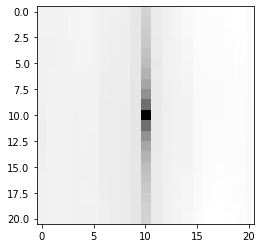

In [72]:
final_mat = result.mean(axis=2)
print(final_mat.shape)
plt.imshow(final_mat, cmap='gray')

## CNN ::: T.B.D

## (참고) STFT
    * STFT(Short-Time Fourier Transform)는 주파수 특성이 시간이 따라 달라지는 사운드를 분석하기 위한 방법이다. 
    * 시계열을 일정한 시간 구간으로 나누고 각 구간에 대해 스펙트럼을 구한 데이터이다. 
    * 시간-주파수의 2차원 데이터로 나타난다.

In [ ]:
print(np_sound)

NameError: ignored

In [ ]:
# iopub_data_rate_limit 설정을 10000000 정도로 크게 해야 한다.
D = np.abs(librosa.stft(np_sound))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max, ), y_axis='linear', x_axis='time')
plt.title('Dual Tone')
plt.ylim(0, 4000)
plt.show()

NameError: ignored

In [ ]:
librosa.display.specshow(librosa.amplitude_to_db(test_sound_2d_norm, ref=np.max), y_axis='linear', x_axis='time')
plt.ylim(0, 260)
plt.gray()
plt.show()

In [ ]:
print(test_sound_2d_norm.shape)
print(test_sound_2d_norm.min(), test_sound_2d_norm.max())